## Kueh Classifier

Let's use the fast.ai approach to see if we can quickly prototype a Kueh classifier.

### fastai2.vision.all.download_images 
Download images listed in text file `url_file` to path `dest`, at most `max_pics`

### fastai2.vision.all.verify_images
Find images in `fns` that can't be opened

### fastai2.vision.all.L 
Behaves like a list of `items` but can also index with list of indices or masks

### fastai2.vision.all.Path 
PurePath subclass that can make system calls.

### fastai2.vision.all.get_image_files
Get image files in `path` recursively, only in `folders`, if specified.

### fastai2.vision.all.DataBlock
Generic container to quickly build `Datasets` and `DataLoaders`

### fastai2.vision.all.ImageBlock
A `TransformBlock` for images of `cls`

### fastai2.vision.all.CategoryBlock
`TransformBlock` for single-label categorical targets

### fast.ai2.vision.all.RandomSplitter
Create function that splits `items` between train/val with `valid_pct` randomly.

### fast.ai2.vision.all.parent_label
Label `item` with the parent folder name.

### fast.ai2.vision.all.Resize
A transform that before_call its state at each `__call__`

### RandomResizedCrop
Picks a random scaled crop of an image and resize it to `size`

### aug_transforms
Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.

### cnn_learner
Build a convnet style learner from `dls` and `arch`

### resnet18
ResNet-18 model from
`"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`

### error_rate
1 - `accuracy`

### ClassificationInterpretation
Interpretation methods for classification models.

### ImageClassifierCleaner
A widget that provides an `ImagesCleaner` with a CNN `Learner`

In [1]:
# Explicit imports
from fastai2.vision.all import (L, Path, 
                                download_images, 
                                verify_images, 
                                get_image_files,
                                DataBlock, 
                                ImageBlock, 
                                CategoryBlock,
                                RandomSplitter,
                                get_image_files,
                                parent_label,
                                Resize,
                                RandomResizedCrop,
                                aug_transforms,
                                cnn_learner,
                                resnet18,
                                error_rate,
                                ClassificationInterpretation)

from fastai2.vision.widgets import ImageClassifierCleaner

# from utils import *
# from fastai2.vision.widgets import *
# from fastai2.vision.widgets import L, Path, get_image_files, CategoryBlock

In [2]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

In [8]:
BING_KEY ='f8cab6ce170e4898898a470f42113182'

path_name = 'kueh'

kueh_types = ['lapis legit',
              'ondeh ondeh',
              'pandan chiffon cake',
              'lapis sagu',
              'bingka ubi', 
              'kueh dadar', 
              'kueh salat']
              'angku kueh']

In [7]:
def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)


def download_all_images(path_name, types, key=BING_KEY):
    """Uses fast.ai utilities to download images from Bing search
    """
    path = Path(path_name)

    # Make directory if it doesn't exist
    if not path.exists():
        path.mkdir()

    for o in types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(BING_KEY, o)
        download_images(dest, urls=results.attrgot('content_url'))

In [9]:
# download_all_images(path_name='kueh', types=['angku kueh'], key=BING_KEY)
download_all_images(path_name='kueh', types=kueh_types, key=BING_KEY)

In [13]:
fns = get_image_files(path_name)
failed = verify_images(fns)

# Remove images that can't be opened
failed.map(Path.unlink);

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


In [14]:
kuehs = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.3, seed=24),
                  get_y=parent_label,
                  item_tfms=Resize(128))

In [17]:
dls = kuehs.dataloaders(path_name)

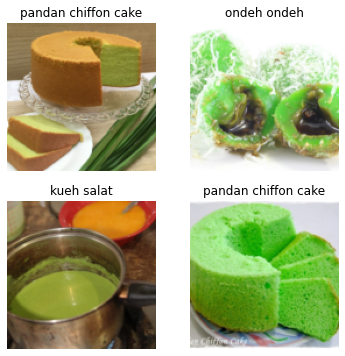

In [18]:
dls.valid.show_batch(max_n=4)

In [20]:
kuehs_transformed = kuehs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = kuehs_transformed.dataloaders(path_name)

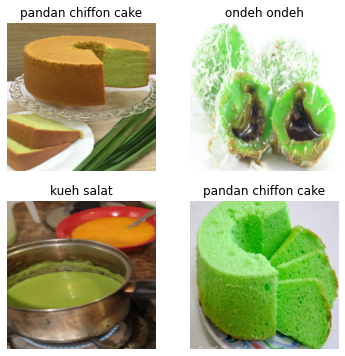

In [21]:
dls.valid.show_batch(max_n=4)

### First run - Before Image Cleaning, 8 Classes

In [175]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.597515,1.026741,0.349854,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.193880,0.814246,0.285714,00:10
1,1.022461,0.655638,0.209913,00:10
2,0.841400,0.647616,0.201166,00:11
3,0.693457,0.662482,0.177843,00:11
4,0.573616,0.639470,0.192420,00:10
5,0.474771,0.627175,0.174927,00:11
6,0.396118,0.620727,0.180758,00:11
7,0.332678,0.624573,0.169096,00:11
8,0.279702,0.619408,0.172012,00:10
9,0.246725,0.620583,0.169096,00:10


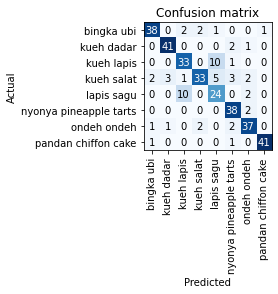

In [176]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Second run - After Image Cleaning, 8 Classes

In [225]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.749522,0.957618,0.332268,00:10


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.062879,0.675071,0.226837,00:10
1,0.904213,0.545058,0.172524,00:10
2,0.724423,0.487422,0.159744,00:10
3,0.571998,0.444370,0.143770,00:10
4,0.466106,0.425168,0.143770,00:11
5,0.381366,0.391600,0.134185,00:10
6,0.310905,0.384670,0.121406,00:10
7,0.259213,0.383820,0.118211,00:10
8,0.223235,0.381151,0.118211,00:10
9,0.195124,0.381897,0.124601,00:10


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/I

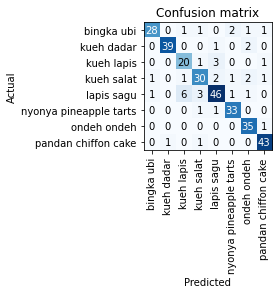

In [226]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Third run - after image cleaning, adding new class (angku kueh)

In [243]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.642534,0.751794,0.229333,00:11


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.981182,0.590536,0.208000,00:11
1,0.792907,0.436990,0.120000,00:10
2,0.616877,0.370104,0.093333,00:10
3,0.475193,0.342248,0.085333,00:11
4,0.374411,0.355660,0.096000,00:10
5,0.296186,0.345998,0.101333,00:10
6,0.241146,0.348889,0.101333,00:10
7,0.194017,0.342368,0.098667,00:11
8,0.161110,0.344111,0.096000,00:10
9,0.131539,0.338631,0.096000,00:11


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/I

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


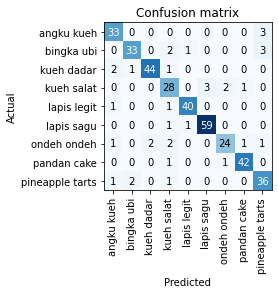

In [245]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Fourth run - back to 8 class

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,2.416958,0.927443,0.287425,00:08


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.989814,0.616351,0.191617,00:06
1,0.867827,0.487214,0.161677,00:07
2,0.739191,0.394398,0.110778,00:07
3,0.604304,0.362413,0.098802,00:08
4,0.512665,0.365555,0.119760,00:08
5,0.416500,0.358439,0.092814,00:08
6,0.338824,0.345901,0.089820,00:07
7,0.280852,0.341972,0.080838,00:07
8,0.233256,0.331607,0.080838,00:08
9,0.189229,0.330662,0.083832,00:07


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/I

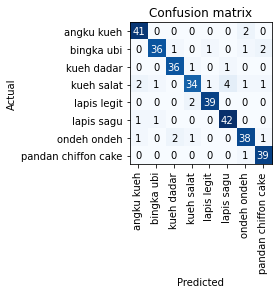

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [25]:
# This is good enough for now! Let's save the model.
learn.export(fname='kueh_class_8.pkl')

In [252]:
fns

(#1322) [Path('kueh/ondeh ondeh/00000004.jpg'),Path('kueh/ondeh ondeh/00000000.jpg'),Path('kueh/ondeh ondeh/00000003.jpg'),Path('kueh/ondeh ondeh/00000006.jpg'),Path('kueh/ondeh ondeh/00000005.jpg'),Path('kueh/ondeh ondeh/00000001.jpg'),Path('kueh/ondeh ondeh/00000011.jpg'),Path('kueh/ondeh ondeh/00000007.jpg'),Path('kueh/ondeh ondeh/00000010.jpg'),Path('kueh/ondeh ondeh/00000012.JPG')...]

In [256]:
learn.dls.vocab

(#9) ['angku kueh','bingka ubi','kueh dadar','kueh salat','lapis legit','lapis sagu','ondeh ondeh','pandan cake','pineapple tarts']

In [255]:
learn.predict(fns[1311])

('lapis legit',
 tensor(4),
 tensor([1.4129e-05, 2.1030e-05, 3.5167e-06, 1.1046e-05, 9.9898e-01, 1.2331e-04,
         1.1780e-04, 2.6732e-06, 7.2937e-04]))

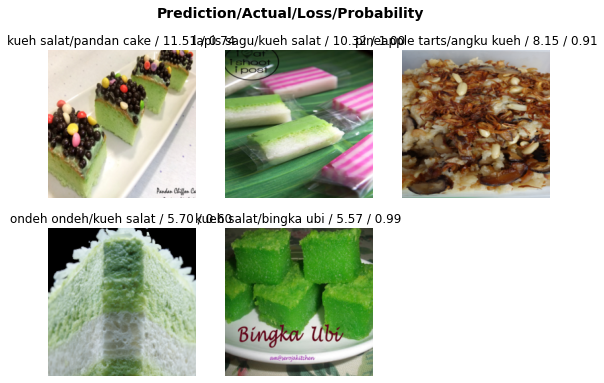

In [257]:
# Show errors
interp.plot_top_losses(5) 

In [228]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [234]:
# Delete 
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [232]:
# Move and rename wtih "reclass" prefix
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), 
                                             f"{str(path/cat)}/reclass_{str(cleaner.fns[idx]).split('/')[-1]}")